# Part 2 – Data Analytics

## 1: Crawl a real-world dataset

### 1.1 Data source overview & Data collection
Register in TMDB and obtain an API Key, and comply with the terms of use.   
NOTICE: "This program uses TMDB and the TMDB APIs but is not endorsed, certified, or otherwise approved by TMDB."  
Access rate limit: 40 times/second   


- Dataset：The Movie Database (TMDB) Public API, movie resource entry point: https://www.themoviedb.org/movie
- Call the Discover Movies API: https://api.themoviedb.org/3/discover/movie
- Data type: Movie metadata:
  - The Discover movies API metadata types include: id, title, release_date, vote_average, vote_count, popularity, original_language, genre_ids, overview ect.
  - For more details, please refer to the official documentation:https://developer.themoviedb.org/reference/discover-movie
- Data extraction scale: 200 movie records were extracted page by page, due to the release year


In [3]:
import requests
import pandas as pd
import ast
import time
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def fetch_tmdb_movies(api_key="7f8c6e28203eb7d6a49fa0caf4466396", start_date="2018-01-01", end_date="2025-12-31", max_results=3000, language="en-UK"):
    """Fetch popular movies from TMDB discover API within a date range."""
    api_key = api_key
    base_url = "https://api.themoviedb.org/3/discover/movie"
    params = {
        "api_key": api_key,
        "language": language,
        "primary_release_date.gte": start_date,
        "primary_release_date.lte": end_date,
        "page": 1,
    }

    records = []
    while len(records) < max_results:
        result = requests.get(base_url, params=params, timeout=10)
        result.raise_for_status()
        data = result.json()
        for movie in data.get("results", []):
            records.append({
                "id": movie.get("id"),
                "title": movie.get("title"),
                "release_date": movie.get("release_date"),
                "vote_average": movie.get("vote_average"),
                "vote_count": movie.get("vote_count"),
                "popularity": movie.get("popularity"),
                "original_language": movie.get("original_language"),
                "genre_ids": movie.get("genre_ids"),
            })
            if len(records) >= max_results:
                break
        if not data.get("total_pages"): 
            break
        elif params["page"] >= data.get("total_pages", 0):
            break
        params["page"] += 1
    movie_data = pd.DataFrame(records)
    return movie_data


### 1.2 Variables and schema
| feature_name            | explanation                                  |
|-------------------|-------------------------------------------|
| `id`              | The movie's unique ID                     |
| `title`           | Movie title                               |
| `release_date`    | Release date                              |
| `vote_average`    | TMDB average rating                       |
| `vote_count`      | The number of people who voted            |
| `popularity`      | Popularity index                          |
| `original_language` | Original language code                  |
| `genre_ids`       | List of type IDs                          |


In [487]:
df_movies = fetch_tmdb_movies(start_date="2018-01-01", end_date="2025-12-31", max_results=3000)
display(df_movies.head())

,id,title,release_date,vote_average,vote_count,popularity,original_language,genre_ids
0,1419406,The Shadow's Edge,2025-08-16,6.400,92,569.8770,en,"[28, 80, 53]"
1,1363123,The Family Plan 2,2025-11-11,6.607,107,398.4084,en,"[28, 35]"
2,1062722,Frankenstein,2025-10-17,7.800,1740,384.5713,en,"[18, 27, 14]"
3,1054867,One Battle After Another,2025-09-23,7.500,1581,309.9881,en,"[28, 53, 80]"
4,1116465,A Legend,2024-07-05,6.672,94,300.6833,zh,"[28, 12, 14]"


### 1.3 Secondary data crawling & Table merging

It's clear that first attempt at scraping data via an API yielded basic information about the films.  
However, based on evaluation, I believe I need more detailed data for each film to improve analysis:
| feature_name              | explanation                 |
|-----------------------|---------------------------|
| `runtime`             | Video length              |
| `budget`              | Film cost/budget          |
| `revenue`             | Box office revenue        |
| `status`              | Release status            |
| `original_title`      | Original language title   |
| `tagline`             | Marketing tagline         |
| `spoken_languages`    | Spoken languages list     |
| `production_countries`| Production countries      |


I merge the two tables using the movie's unique ID.


In [ ]:
def fetch_movie_detail(movie_id, api_key="7f8c6e28203eb7d6a49fa0caf4466396"):
    url = f"https://api.themoviedb.org/3/movie/{movie_id}"
    resp = requests.get(url, params={"api_key": api_key}, timeout=10)
    resp.raise_for_status()
    details = resp.json()

    spoken_lang_names = ", ".join(
        sorted(
            {
                lang.get("english_name") or lang.get("name")
                for lang in (details.get("spoken_languages") or [])
                if lang.get("english_name") or lang.get("name")
            }
        )
    )
    production_country_codes = ", ".join(
        sorted(
            {
                country.get("iso_3166_1") or country.get("name")
                for country in (details.get("production_countries") or [])
                if country.get("iso_3166_1") or country.get("name")
            }
        )
    )

    return {
        "id": movie_id,
        "runtime": details.get("runtime"),
        "budget": details.get("budget"),
        "revenue": details.get("revenue"),
        "status": details.get("status"),
        "original_title": details.get("original_title"),
        "tagline": details.get("tagline"),
        "spoken_languages": spoken_lang_names,
        "production_countries": production_country_codes,
    }

detail_record = []
for movie_id in df_movies["id"]:
    detail_record.append(fetch_movie_detail(movie_id))
    time.sleep(0.1)  # add a sleep time to control access frequency

df_movie_details = pd.DataFrame(detail_record)

display(df_movie_details.head())

"""merge the two tables with unique ID"""
df_movie_full = df_movies.merge(df_movie_details, on = "id", how = "left")
display(df_movie_full.head())


,id,runtime,budget,revenue,status,original_title,tagline,spoken_languages,production_countries
0,1419406,142,0,702538,Released,捕风追影,,Mandarin,"CN, HK"
1,1363123,106,0,0,Released,The Family Plan 2,"Deck the halls, dodge the bad guys.","English, French, Mandarin, Russian",US
2,1062722,150,120000000,480678,Released,Frankenstein,Only monsters play God.,"Danish, English, French","CA, US"
3,1054867,162,130000000,201175005,Released,One Battle After Another,"Some search for battle, others are born into i...","English, Spanish, Telugu",US
4,1116465,129,0,11242056,Released,传说,,"English, Mandarin","CN, HK"


,id,title,release_date,vote_average,vote_count,popularity,original_language,genre_ids,runtime,budget,revenue,status,original_title,tagline,spoken_languages,production_countries
0,1419406,The Shadow's Edge,2025-08-16,6.400,92,569.8770,en,"[28, 80, 53]",142,0,702538,Released,捕风追影,,Mandarin,"CN, HK"
1,1363123,The Family Plan 2,2025-11-11,6.607,107,398.4084,en,"[28, 35]",106,0,0,Released,The Family Plan 2,"Deck the halls, dodge the bad guys.","English, French, Mandarin, Russian",US
2,1062722,Frankenstein,2025-10-17,7.800,1740,384.5713,en,"[18, 27, 14]",150,120000000,480678,Released,Frankenstein,Only monsters play God.,"Danish, English, French","CA, US"
3,1054867,One Battle After Another,2025-09-23,7.500,1581,309.9881,en,"[28, 53, 80]",162,130000000,201175005,Released,One Battle After Another,"Some search for battle, others are born into i...","English, Spanish, Telugu",US
4,1116465,A Legend,2024-07-05,6.672,94,300.6833,zh,"[28, 12, 14]",129,0,11242056,Released,传说,,"English, Mandarin","CN, HK"


Create a CSV file with descriptions for each column element.

In [489]:
column_descriptions = {
    "id": "Unique movie ID",
    "title": "Localized title returned by API",
    "release_date": "Release date (YYYY-MM-DD)",
    "vote_average": "TMDB average rating",
    "vote_count": "Number of votes submitted",
    "popularity": "Popularity index (TMDB metric)",
    "original_language": "Original language ISO code",
    "genre_ids": "List of TMDB genre IDs",
    "runtime": "Runtime in minutes",
    "budget": "Production budget in USD",
    "revenue": "Box office revenue in USD ",
    "status": "Release status flag",
    "original_title": "Original language title",
    "tagline": "Marketing tagline",
    "spoken_languages": "Comma-separated spoken languages",
    "production_countries": "Comma-separated production countries or ISO codes"
}

schema_records = [
    {"column": col, "description": column_descriptions[col]}
    for col in df_movie_full.columns
]

schema_df = pd.DataFrame(schema_records)


### 1.4 Storage as CSV
Storage path：local



In [ ]:
output_path = Path("C:\\Users\\10525\\Desktop\\SDPA-final\\SDPA_EMATM0048_2720314\\data\\tmdb_movies_2020-2025.csv")
output_path.parent.mkdir(parents=True,exist_ok=True)
df_movie_full.to_csv(output_path)

schema_path = Path("C:/Users/10525/Desktop/SDPA-final/SDPA_EMATM0048_2720314/data/movie_schema.csv")
schema_path.parent.mkdir(parents=True, exist_ok=True)
schema_df.to_csv(schema_path, index=False)


## 2: Perform data preparation and cleaning 

### 2.1 Load data
- Explains the parameters for using `pandas.read_csv` to read CSV files.
- Record the initial DataFrame shape and data type checks.

In [4]:
movie_data = pd.read_csv("C:\\Users\\10525\\Desktop\\SDPA-final\\SDPA_EMATM0048_2720314\\data\\tmdb_movies_2020-2025.csv")
movie_data.drop(columns=["Unnamed: 0"], inplace = True)
movie_schema = pd.read_csv("C:/Users/10525/Desktop/SDPA-final/SDPA_EMATM0048_2720314/data/movie_schema.csv")

In [5]:
data_shape = movie_data.shape
print(f"initial data shape: {data_shape[0]} rows, {data_shape[1]} columns")

initial data shape: 3000 rows, 16 columns


In [6]:
movie_data.dtypes

id                        int64
title                    object
release_date             object
vote_average            float64
vote_count                int64
popularity              float64
original_language        object
genre_ids                object
runtime                   int64
budget                    int64
revenue                   int64
status                   object
original_title           object
tagline                  object
spoken_languages         object
production_countries     object
dtype: object

In [7]:
movie_data.describe()

,id,vote_average,vote_count,popularity,runtime,budget,revenue
count,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3.000000e+03,3.000000e+03
mean,8.885274e+05,5.663052,771.421000,11.387795,96.087000,1.389764e+07,4.109050e+07
std,3.197355e+05,2.167885,2256.521961,23.097464,35.758174,4.364904e+07,1.731878e+08
min,1.349400e+04,0.000000,0.000000,5.954400,0.000000,0.000000e+00,0.000000e+00
25%,6.069620e+05,5.200000,6.000000,6.501600,87.000000,0.000000e+00,0.000000e+00
50%,8.710865e+05,6.221000,32.500000,7.368800,97.000000,0.000000e+00,0.000000e+00
75%,1.143170e+06,7.000000,292.250000,9.305725,110.000000,7.250000e+04,1.788885e+05
max,1.580253e+06,10.000000,31155.000000,569.877000,676.000000,5.839000e+08,2.799439e+09


The extracted data contains null values, and some data is unreasonable  
Therefore, "Missing values & Outliers" will be to preprocess the data to make it as compatible with our requirements as possible.

### 2.2 Missing values & Outliers
- Describe the methods and strategies for detecting missing values ​​(deletion/filling/interpolation), and explain the reasons for choosing them.
- Describe the rules or statistical methods for detecting outliers/inconsistent data, and the corrective/filtering measures and their basis.

Clearly, `vote_average`, `vote_count`, `budget`, `revenue`, and `runtime` cannot be 0. The only possible reasons are the lack of audience ratings, undisclosed budgets, revenues, and runtime.  
Therefore, we convert the 0 values ​​in these columns to **NaN** values.

In [8]:
"""Convert unreasonable 0 values ​​to NaN"""
conversion_list = [
    "vote_average",
    "vote_count",
    "budget",
    "revenue",
    "runtime"
]
movie_data[conversion_list] = movie_data[conversion_list].replace(0, pd.NA)

In [9]:
"""Calculate the number of missing values ​​and the missing rate."""
def missing_report():
    miss_report = pd.DataFrame({
        "missing_count": movie_data.isna().sum(),
        "missing_pct": movie_data.isna().mean().round(3)
        })
    return miss_report

display(missing_report())

,missing_count,missing_pct
id,0,0.000
title,0,0.000
release_date,0,0.000
vote_average,264,0.088
vote_count,261,0.087
popularity,0,0.000
original_language,0,0.000
genre_ids,0,0.000
runtime,89,0.030
budget,2207,0.736


`Revenue` and `budget` will be important data for subsequent calculations. They are crucial features for evaluating a film's success, so we have removed all movies with empty columns from the statistics.   

In [10]:
"""remove movies with empty value in budget and revenue"""
movie_data = movie_data.loc[~movie_data["budget"].isnull()]
movie_data = movie_data.loc[~movie_data["revenue"].isnull()]


"""dtype conversion"""
for col in ["budget", "revenue", "vote_average", "vote_count", "runtime"]:
    movie_data[col] = pd.to_numeric(movie_data[col], errors="coerce")
    
movie_data.shape

(600, 16)

In [11]:
"""remove movies with empty value in "genre_ids"(doubel check "genre_ids" is not empty list) """
def valid_genres(value):
    if pd.isna(value):
        return False
    if isinstance(value, str):
        stripped = value.strip()
        return bool(stripped and stripped != "[]")
    try:
        return len(value) > 0
    except TypeError:
        return False

movie_data = movie_data[movie_data["genre_ids"].apply(valid_genres)]
movie_data.shape

(600, 16)

For null values ​​in features: `tagline`, `spoken_languages` and `production_countries`, format normalization will be performed to preserve data integrity to the greatest extent possible.

In [12]:
"""normalization in formatting terms"""
text_fill_cols = ["tagline", "spoken_languages", "production_countries"]
for col in text_fill_cols:
    movie_data[col] = movie_data[col].fillna("Unknown")

def normalize_multivalue_field(value):
    if value is pd.NA or value is None or value == "Unknown":
        return ["Unknown"]
    if isinstance(value, list):
        cleaned = [str(item).strip() for item in value if str(item).strip()]
        return cleaned or ["Unknown"]
    parts = [item.strip() for item in str(value).split(",") if item.strip()]
    return parts or ["Unknown"]

movie_data["spoken_languages"] = movie_data["spoken_languages"].apply(normalize_multivalue_field)
movie_data["production_countries"] = movie_data["production_countries"].apply(normalize_multivalue_field)

display(movie_data[["tagline", "spoken_languages", "production_countries"]].head())
display(missing_report())

,tagline,spoken_languages,production_countries
2,Only monsters play God.,"[Danish, English, French]","[CA, US]"
3,"Some search for battle, others are born into i...","[English, Spanish, Telugu]",[US]
7,Fight for justice.,"[Cantonese, English, Japanese, Mandarin]","[CN, HK]"
9,First hunt. Last chance.,[English],[US]
12,You will be changed.,[English],[US]


,missing_count,missing_pct
id,0,0.000
title,0,0.000
release_date,0,0.000
vote_average,1,0.002
vote_count,1,0.002
popularity,0,0.000
original_language,0,0.000
genre_ids,0,0.000
runtime,0,0.000
budget,0,0.000


### 2.3 Feature engineering
record newly added or transformed features :
 - date parsing
 - category coding
 - normalization/standardization
 - binning

Having completed the processing of all 0 and null values  
proceed with outlier identification and handling

In [13]:
def remove_outliers(feature, lower, upper, data_frame = movie_data):
    before = len(data_frame)
    filtered = data_frame[data_frame[feature].between(lower, upper, inclusive="both")].copy()
    removed = before - len(filtered)

    print(f"Removed {removed} rows with {feature} outside [{lower}, {upper}]")
    return filtered

In [14]:
def plot_box_with_points(series, title, xlabel):
    """Box plot & Data distribution"""
    cleaned = series.dropna()
    fig, ax = plt.subplots(figsize=(6, 3.5))
    sns.boxplot(x=cleaned, ax=ax, color ="white", fliersize=0)
    sns.stripplot(x=cleaned, ax=ax, color="green", alpha=0.45, size=3, jitter=0.15)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    plt.show()


def plot_dual_box_with_points(main_series, cold_series, xlabel, suptitle):
    """Box plot & Data distribution for both main_series & cold_series"""
    if cold_series is not None:
        main_cleaned = main_series.dropna()
        cold_cleaned = cold_series.dropna() 
    else:
        main_cleaned = main_series.dropna()
        cold_cleaned = pd.Series(dtype=float)

    fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharex=False) 
    """Due to the characteristics of cold_movie data, the x-axis needs to be scaled."""
    datasets = [
        ("Main dataset", main_cleaned),
        ("Cold movies", cold_cleaned),
    ]

    for ax, (subtitle, values) in zip(axes, datasets):
        if values.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=10)
            ax.set_xlabel(xlabel)
            ax.set_title(subtitle)
            ax.set_yticks([])
            continue
        sns.boxplot(x=values, ax=ax, color="white", fliersize=0)
        sns.stripplot(x=values, ax=ax, color="green", alpha=0.45, size=3, jitter=0.15)
        ax.set_xlabel(xlabel)
        ax.set_title(subtitle)

    """x-axis scaled five times"""
    main_min, main_max = main_cleaned.min(), main_cleaned.max()
    span = main_max - main_min
    cold_axis = axes[1]
    cold_min = cold_cleaned.min()
    cold_max = cold_cleaned.max()
    desired_span = span / 5
    cold_max = min(cold_max, cold_min + desired_span)
    cold_axis.set_xlim(cold_min, cold_max)

    fig.suptitle(suptitle)
    plt.tight_layout()
    plt.show()


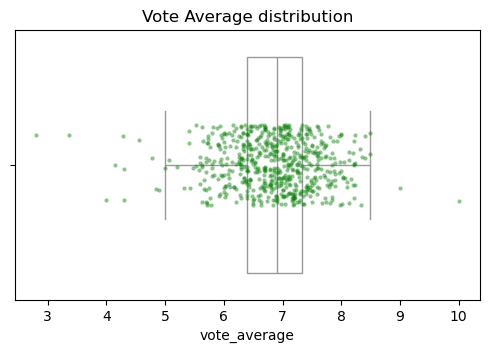

In [15]:
with pd.option_context("display.float_format", "{:.2f}".format):
    plot_box_with_points(movie_data["vote_average"], "Vote Average distribution", "vote_average")

`vote_average`: observing the distribution plot, we can see that there are a very small number of extreme data points  
The rule states that values ​​with `vote_average` less than 4.5 or greater than 9.5 are considered as extreme outliers and will be removed.

In [16]:
movie_data = remove_outliers(feature = "vote_average", lower = 4.5, upper = 9.5)

Removed 9 rows with vote_average outside [4.5, 9.5]


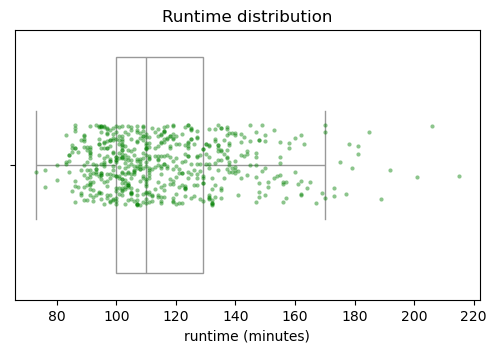

In [17]:
with pd.option_context("display.float_format", "{:.2f}".format):
    plot_box_with_points(movie_data["runtime"], "Runtime distribution", "runtime (minutes)")

`runtime`: Similar to `vote_average`, outlier identification is performed based on the common movie duration [60, 200].

In [18]:
movie_data = remove_outliers(feature = "runtime", lower = 60, upper = 200)

Removed 4 rows with runtime outside [60, 200]


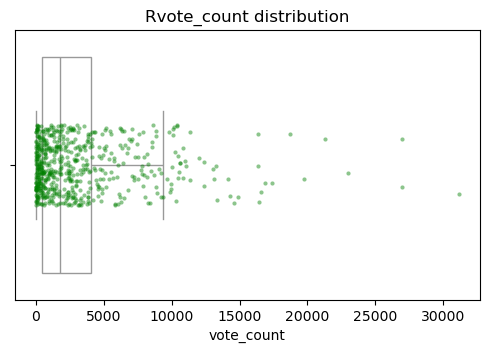

In [19]:
with pd.option_context("display.float_format", "{:.2f}".format):
    plot_box_with_points(movie_data["vote_count"], "Rvote_count distribution", "vote_count")


`vote_count`: The data is naturally "long-tailed," with some movies receiving only a few votes while others have hundreds of thousands, reflecting the films' popularity. Directly deleting high or low votes would result in the loss of crucial information. Therefore, we store excessively unpopular films (`vote_count` < 50) in a separate DataFrame: cold_movies for subsequent classification and analysis.

`vote_count_log`: the log transformation of `vote_count` is used in subsequent analysis/modeling to control the impact of extreme values.

In [20]:
import numpy as np

"""category the movies by vote_count"""
min_votes = 50
cold_movies = movie_data[movie_data["vote_count"] < min_votes].copy()
movie_data = movie_data[movie_data["vote_count"] >= min_votes].copy()

print(f"Identified {len(cold_movies)} low-vote movies (< {min_votes} ratings) for separate analysis.")
print(f"Remaining dataset rows: {len(movie_data)}")

"""creat column "vote_count_log" to control the impact of extreme values"""
movie_data["vote_count_log"] = np.log1p(movie_data["vote_count"])


Identified 40 low-vote movies (< 50 ratings) for separate analysis.
Remaining dataset rows: 555


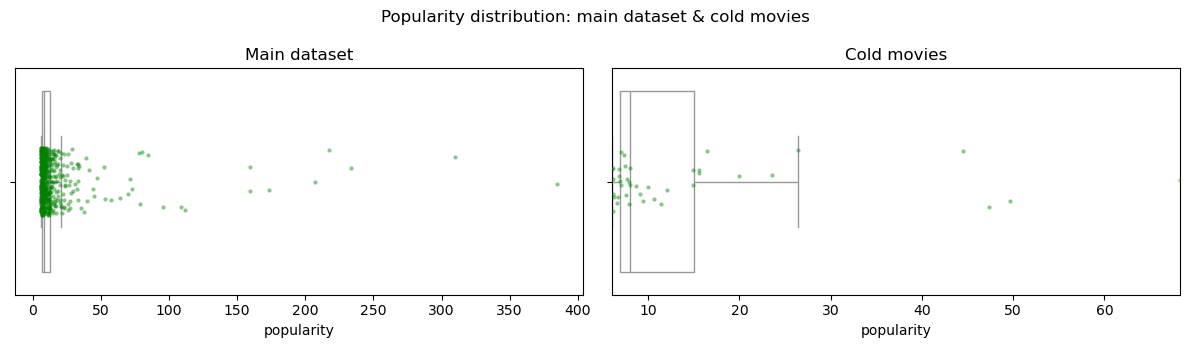

In [21]:
cold_series = cold_movies["popularity"]
plot_dual_box_with_points(
    movie_data["popularity"],
    cold_series,
    "popularity",
    "Popularity distribution: main dataset & cold movies"
)

`popularity`: Calculate the 99% quantile of popularity, removing the top 1% movies to prevent them from dominating the statistics.
`popularity_log`:  the log transformation of `popularity` is used in subsequent analysis/modeling to convenient regression/visualization

Tips: The data in **cold_movie** has a "smoother long tail" compared to **main_data**, so it doesn't need to be truncated.

In [22]:
pop_clip = 0.99
popularity_cap = movie_data["popularity"].quantile(pop_clip)
movie_data["popularity_clipped"] = movie_data["popularity"].clip(upper=popularity_cap)
movie_data["popularity_log"] = np.log1p(movie_data["popularity_clipped"])

print(f"Popularity values above the {pop_clip:.0%} quantile ({popularity_cap}) were clipped.")

Popularity values above the 99% quantile (165.9272120000005) were clipped.


After processing, we can visualize the main movie_data using `popularity_log` as follow.

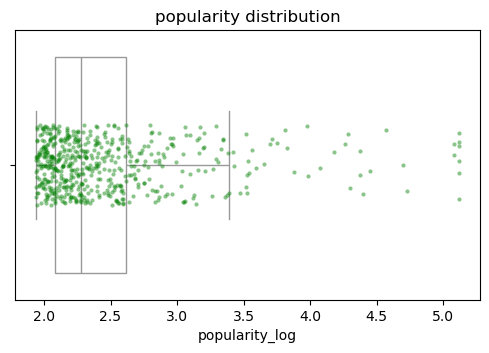

In [23]:
with pd.option_context("display.float_format", "{:.2f}".format):
    plot_box_with_points(movie_data["popularity_log"], "popularity distribution", "popularity_log")

Budget distribution & Revenue distribution for both main and cold movies as below

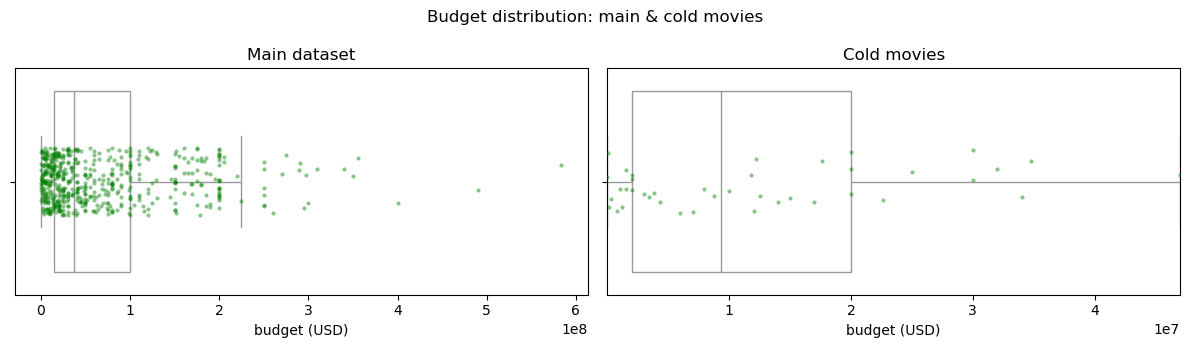

In [24]:
cold_series = cold_movies["budget"]
plot_dual_box_with_points(
    movie_data["budget"],
    cold_series,
    "budget (USD)",
    "Budget distribution: main & cold movies"
)

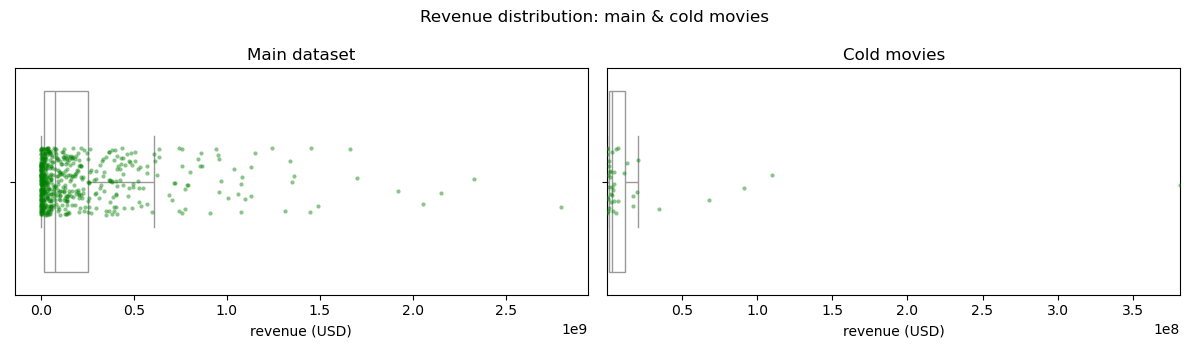

In [25]:
cold_series = cold_movies["revenue"]
plot_dual_box_with_points(
    movie_data["revenue"],
    cold_series,
    "revenue (USD)",
    "Revenue distribution: main & cold movies"
)

In [26]:
movie_data = remove_outliers(feature = "revenue", lower = 10000, upper = np.inf)

Removed 10 rows with revenue outside [10000, inf]


**main dataset**: The `revenue` and `budget` in the main dataset still exhibit a "long tail effect," but especially their coupling, we use the derived metric `ROI` for optimization.
 - tips :`ROI`= `revenue` / `budget`,  `ROI` allows for a more direct comparison of the films' economic performance.


**cold movies**: compared to the **main dataset**, the spans for both `budget` and `revenue` are shapely reduced, the box plots saw most of the scaled horizontal axis, and there are fewer outliers, making them suitable for independent analysis.

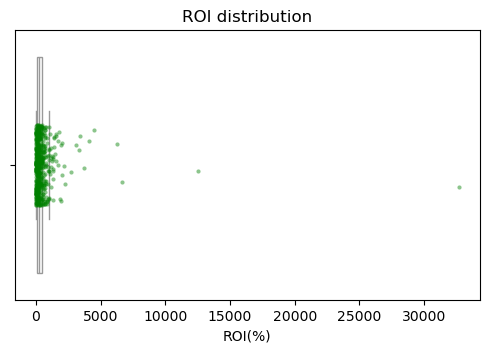

In [27]:
"""ROI = revenue / budget"""
movie_data["ROI"] = movie_data["revenue"] / movie_data["budget"]

with pd.option_context("display.float_format", "{:.4f}".format):
    plot_box_with_points(movie_data["ROI"] * 100, "ROI distribution", "ROI(%)")

Normally, the `ROI` will not exceed 2000%.   
However, to avoid the emergence of ultra-low-budget films that unexpectedly become hits, we added a column `ROI_flag` to distinguish whether their `ROI` is over 2000%, so as to facilitate subsequent classification and analysis. - (binning)

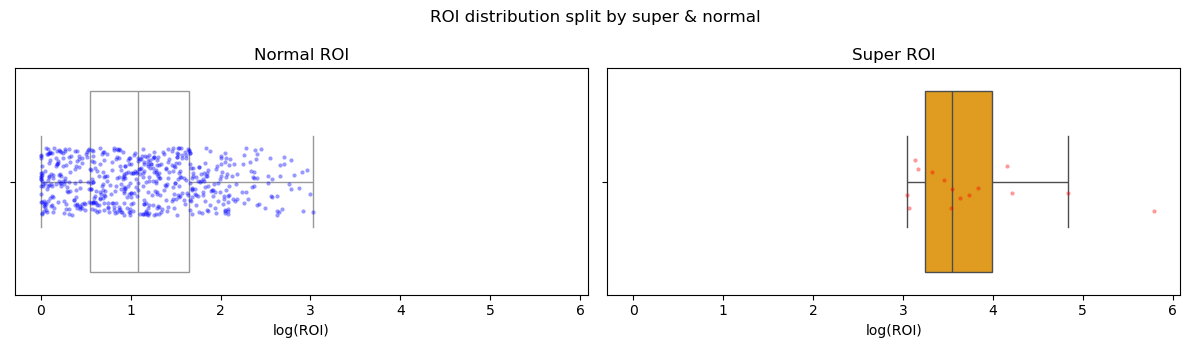

In [28]:
roi_max = 20
movie_data["ROI_log"] = np.log1p(movie_data["ROI"])
movie_data["ROI_flag"] = np.where(movie_data["ROI"] > roi_max, "super_ROI", "normal_ROI")

super_ROI = movie_data.loc[movie_data["ROI_flag"] == "super_ROI"]["ROI_log"]
normal_ROI = movie_data.loc[movie_data["ROI_flag"] == "normal_ROI"]["ROI_log"]

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharex=True)
sns.boxplot(x=normal_ROI, ax=axes[0], color="white", fliersize=0)
sns.stripplot(x=normal_ROI, ax=axes[0], color="blue", alpha=0.4, size=3, jitter=0.15)
axes[0].set_title("Normal ROI")
axes[0].set_xlabel("log(ROI)")

sns.boxplot(x=super_ROI, ax=axes[1], color="orange", fliersize=0)
sns.stripplot(x=super_ROI, ax=axes[1], color="red", alpha=0.4, size=3, jitter=0.15)
axes[1].set_title("Super ROI")
axes[1].set_xlabel("log(ROI)")

fig.suptitle("ROI distribution split by super & normal")
plt.tight_layout()
plt.show()

After binning by "super_ROI" and "normal_ROI", the distribution is relatively uniform and concentrated, making it suitable as an independent analysis.

In [29]:
movie_data["vote_count_log"] = np.log1p(movie_data["vote_count"])
movie_data["popularity_log"] = np.log1p(movie_data["popularity"])

with pd.option_context("display.float_format", "{:.2f}".format):
    display(movie_data.describe())

,id,vote_average,vote_count,popularity,runtime,budget,revenue,ROI,ROI_log,vote_count_log,popularity_log
count,590.00,589.00,589.00,590.00,590.00,590.00,590.00,590.00,590.00,589.00,590.00
mean,732571.53,6.85,3235.76,15.84,115.65,64539854.26,204574627.57,4.53,1.19,7.13,2.49
std,300205.18,0.76,4121.02,29.52,22.40,76284414.57,344713841.17,15.51,0.84,1.72,0.62
min,38700.00,2.80,2.00,5.96,73.00,3000.00,10000.00,0.00,0.00,1.10,1.94
25%,492840.50,6.40,495.00,7.04,100.00,12625000.00,11111543.25,0.74,0.56,6.21,2.08
50%,641680.50,6.90,1792.00,8.74,110.00,31182000.00,62807916.50,2.03,1.11,7.49,2.28
75%,986066.50,7.33,4113.00,12.98,129.00,90000000.00,225877052.50,4.37,1.68,8.32,2.64
max,1549726.00,9.00,31155.00,384.57,215.00,583900000.00,2799439100.00,326.70,5.79,10.35,5.95


## 3: Perform exploratory analysis

### 3.1 Descriptive statistics
List the core statistics that need to be reported (mean, median, range, etc.) and their business significance:  
 - `count`: sample size, used to determine data reliability  
 - `mean`: the average score reflects the overall level
 - `median`(`50%`): avoid being affected by extreme values, it represents typical film performance
 - `min`&`max`: extreme values ​​indicate whether extreme cases exist
 - `range`: reflecting data span


In [30]:
stats_cols = ["vote_average", "vote_count", "popularity", "runtime", "budget", "revenue", "ROI"]
desc = movie_data[stats_cols].describe().T
desc["range"] = desc["max"] - desc["min"]
with pd.option_context("display.float_format", "{:.2f}".format):
    display(desc[["count", "mean", "50%", "std", "min", "max", "range"]])

,count,mean,50%,std,min,max,range
vote_average,589.00,6.85,6.90,0.76,2.80,9.00,6.20
vote_count,589.00,3235.76,1792.00,4121.02,2.00,31155.00,31153.00
popularity,590.00,15.84,8.74,29.52,5.96,384.57,378.61
runtime,590.00,115.65,110.00,22.40,73.00,215.00,142.00
budget,590.00,64539854.26,31182000.00,76284414.57,3000.00,583900000.00,583897000.00
revenue,590.00,204574627.57,62807916.50,344713841.17,10000.00,2799439100.00,2799429100.00
ROI,590.00,4.53,2.03,15.51,0.00,326.70,326.70


The statistical items will have different meanings in different business scenarios, and will be used in the detailed analysis below.  
For example:  
the `mean` value of `vote_count` reflects the overall level of movie vote number  
the `mean` value of `popularity` reflects the overall level of film popularity score


### 3.2 Distributions 
Use planning histograms/density plots， Explain the questions each plot is meant to answer, the patterns/anomalies to watch, and possible explanations

The distribution data is the cleaned data from the previous section, but box plots are more effective at identifying outliers, while bar plots can be used to observe the overall distribution trend of the data sample.

#### 3.2.1 `vote_average` distributions:

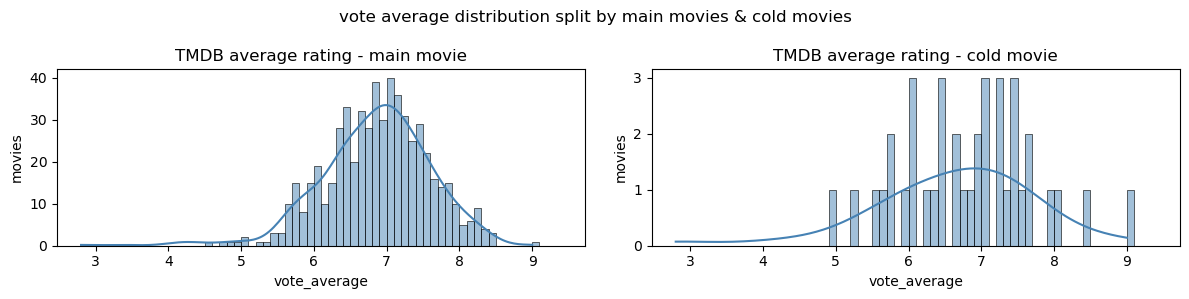

In [31]:
average = movie_data['vote_average']
cold_average = cold_movies['vote_average']
desc = movie_schema.loc[movie_schema['column'] == 'vote_average', 'description'].iloc[0]

fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=False)

sns.histplot(average, bins=np.arange(4.5,9.5,0.1), kde=True, color='steelblue',ax=axes[0])
axes[0].set_title(f"{desc} - main movie")
axes[0].set_xlabel("vote_average")
axes[0].set_ylabel('movies')

sns.histplot(cold_average, bins=np.arange(4.5,9.5,0.1), kde=True, color='steelblue',ax=axes[1])
axes[1].set_title(f"{desc} - cold movie")
axes[1].set_xlabel("vote_average")
axes[1].set_ylabel('movies')

fig.suptitle("vote average distribution split by main movies & cold movies")
plt.tight_layout()
plt.show()


 Insight:
 - Main Movies: The ratings follow a near-normal distribution centered around 6.8, suggesting that most commercially successful films are "average" in quality, with very few masterpieces (`vote_average`>8.5).

 - Cold Movies: The distribution is more flat. This indicates that niche films are polarizing—they are either hidden gems (high scores with low votes) or obscure failures.

 The disparity highlights a **"Niche Effect"**. Cold Movies are often more polarizing. They tend to be either hidden gems or obscure failures. But Main Movies must appeal to a broader demographic, resulting in a stabilized but "average" rating profile.

#### 3.2.2  `vote_count` distributions:

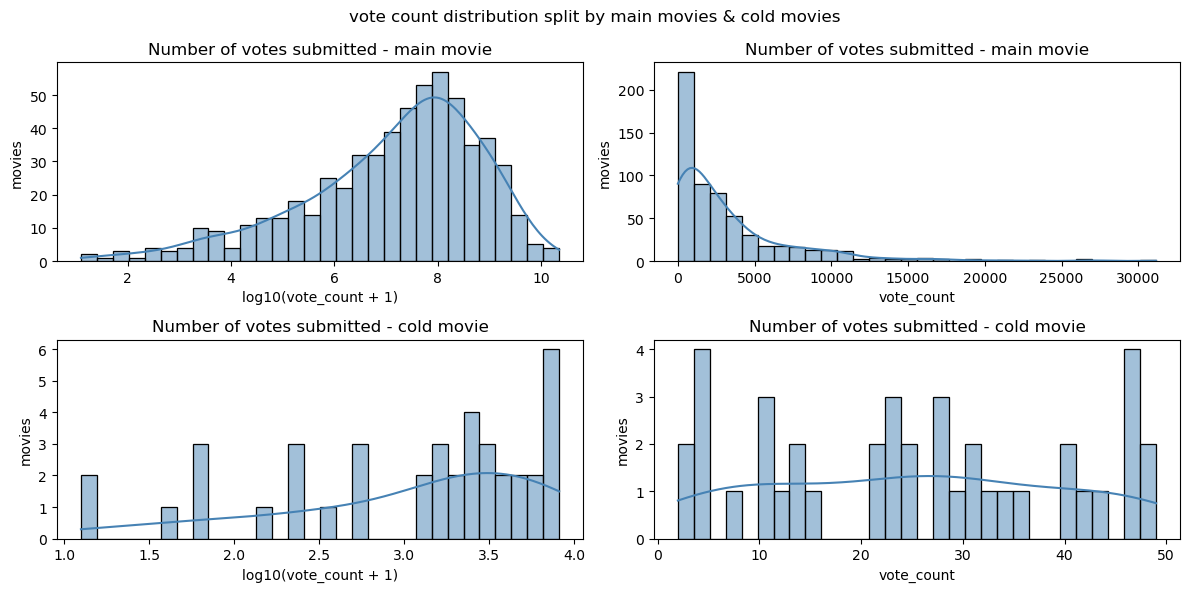

In [32]:
counts = movie_data['vote_count']
counts_log = movie_data['vote_count_log']
cold_counts_log = np.log1p(cold_movies['vote_count'])
cold_counts = cold_movies['vote_count']
desc = movie_schema.loc[movie_schema['column'] == 'vote_count', 'description'].iloc[0]

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=False)

sns.histplot(counts_log, bins=30, kde=True, color='steelblue',ax=axes[0, 0])
axes[0,0].set_title(f"{desc} - main movie")
axes[0,0].set_xlabel("log10(vote_count + 1)")
axes[0,0].set_ylabel('movies')

sns.histplot(counts, bins=30, kde=True, color='steelblue',ax=axes[0, 1])
axes[0,1].set_title(f"{desc} - main movie")
axes[0,1].set_xlabel("vote_count")
axes[0,1].set_ylabel('movies')

sns.histplot(cold_counts_log, bins=30, kde=True, color='steelblue',ax=axes[1, 0])
axes[1,0].set_title(f"{desc} - cold movie")
axes[1,0].set_xlabel("log10(vote_count + 1)")
axes[1,0].set_ylabel('movies')

sns.histplot(cold_counts, bins=30, kde=True, color='steelblue',ax=axes[1, 1])
axes[1,1].set_title(f"{desc} - cold movie")
axes[1,1].set_xlabel("vote_count")
axes[1,1].set_ylabel('movies')

fig.suptitle("vote count distribution split by main movies & cold movies")
plt.tight_layout()
plt.show()

insight:  

 - The original `vote_count` plot (top right) shows a severely right-skewed distribution, a typical data distribution of social data.
  - The log transformed plot (top left) shows this characteristic, presenting a structure closer to a normal distribution. This validates the necessity of using `vote_count_log` in any future correlation or regression analysis.

Business:

This confirms the film industry's **"head effect"**. A very small number of "blockbusters" attract the attention of the vast majority of viewers. cold movies represent the **"long tail"** of the industry: risky products fail to break through the exposure required for mainstream commercial success.

#### 3.2.3 `popularity` distributions:

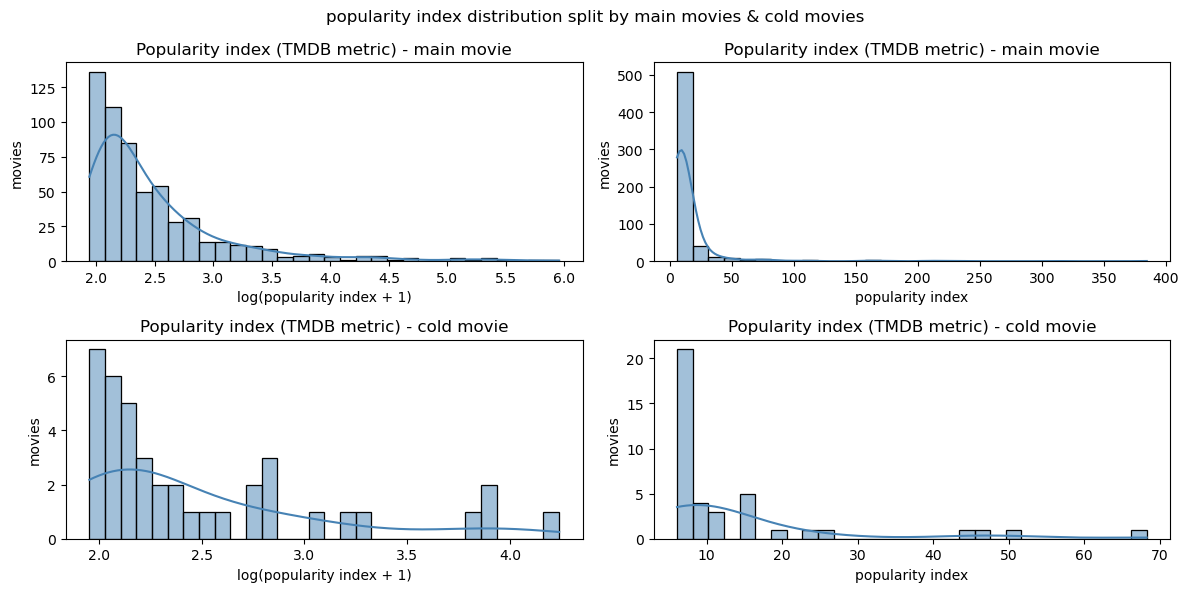

In [33]:
popularity = movie_data["popularity"]
popularity_log = movie_data["popularity_log"]
cold_popularity = cold_movies["popularity"]
cold_popularity_log = np.log1p(cold_movies["popularity"])

desc = movie_schema.loc[movie_schema['column'] == 'popularity', 'description'].iloc[0]

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=False)

sns.histplot(popularity_log, bins=30, kde=True, color='steelblue',ax=axes[0, 0])
axes[0,0].set_title(f"{desc} - main movie")
axes[0,0].set_xlabel("log(popularity index + 1)")
axes[0,0].set_ylabel('movies')

sns.histplot(popularity, bins=30, kde=True, color='steelblue',ax=axes[0, 1])
axes[0,1].set_title(f"{desc} - main movie")
axes[0,1].set_xlabel("popularity index")
axes[0,1].set_ylabel('movies')

sns.histplot(cold_popularity_log, bins=30, kde=True, color='steelblue',ax=axes[1, 0])
axes[1,0].set_title(f"{desc} - cold movie")
axes[1,0].set_xlabel("log(popularity index + 1)")
axes[1,0].set_ylabel('movies')

sns.histplot(cold_popularity, bins=30, kde=True, color='steelblue',ax=axes[1, 1])
axes[1,1].set_title(f"{desc} - cold movie")
axes[1,1].set_xlabel("popularity index")
axes[1,1].set_ylabel('movies')

fig.suptitle("popularity index distribution split by main movies & cold movies")
plt.tight_layout()
plt.show()

insight:


Similarily, it can be observed that even after log processing, the `popularity` of both cold dataset and main dataset still exhibits a clear **"long-tail"** distribution. I still believe this is due to the typical **"head effect"** in the movie industry, where the `popularity` index of top-rated moviess are significantly higher.

#### 3.2.4 `runtime` distributions:


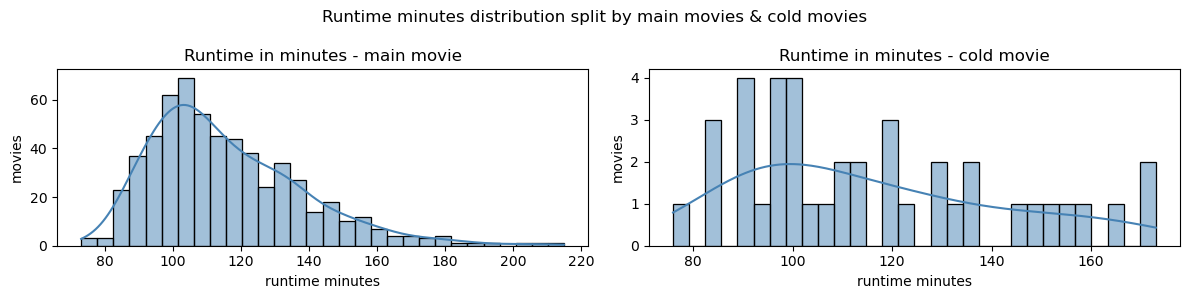

In [34]:
runtime = movie_data["runtime"]
cold_runtime = cold_movies["runtime"]

desc = movie_schema.loc[movie_schema['column'] == 'runtime', 'description'].iloc[0]

fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=False)

sns.histplot(runtime, bins=30, kde=True, color='steelblue',ax=axes[0])
axes[0].set_title(f"{desc} - main movie")
axes[0].set_xlabel("runtime minutes")
axes[0].set_ylabel('movies')

sns.histplot(cold_runtime, bins=30, kde=True, color='steelblue',ax=axes[1])
axes[1].set_title(f"{desc} - cold movie")
axes[1].set_xlabel("runtime minutes")
axes[1].set_ylabel('movies')

fig.suptitle("Runtime minutes distribution split by main movies & cold movies")
plt.tight_layout()
plt.show()

insight:

It clearly defines the **"Commercial Best Spot"**: 90 and 150 minutes.
- **Theater Economics:** Movies under 150 minutes allow theaters to schedule more screenings per day, maximizing ticket sales potential.
- **Audience Attention:** 90-100 minutes is the standard tolerance for casual viewing.

The fact that the `runtime` of the cold dataset and the main dataset are similar indirectly suggests that `runtime` **is not a direct reason for the unpopularity of the movies**.

#### 3.2.5 `ROI` distributions:

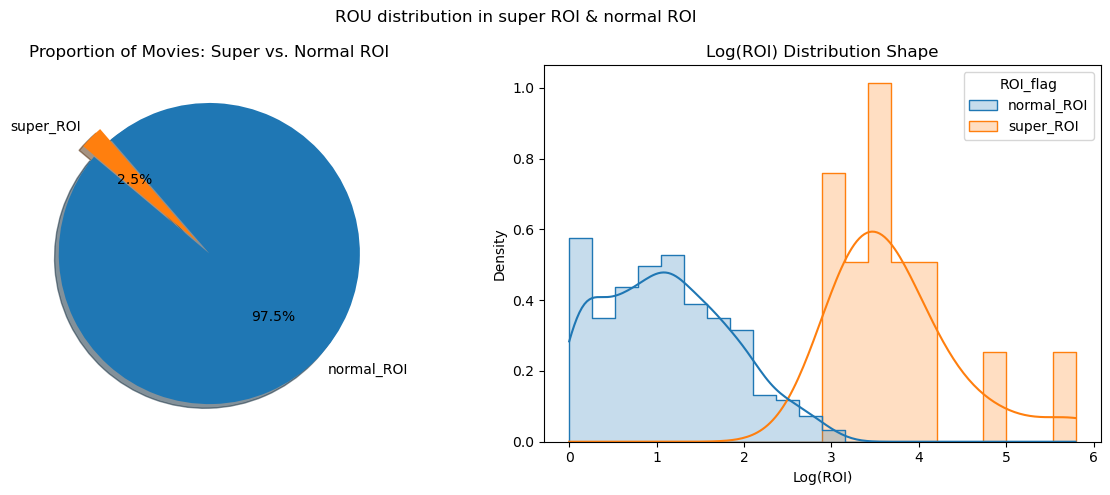

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

roi_counts = movie_data['ROI_flag'].value_counts()
axes[0].pie(roi_counts, 
            labels=roi_counts.index, 
            autopct='%1.1f%%', 
            startangle=140,   
            explode=(0, 0.1), 
            shadow=True)
axes[0].set_title("Proportion of Movies: Super vs. Normal ROI")

sns.histplot(
    data=movie_data, 
    x='ROI_log', 
    hue='ROI_flag', 
    element="step", 
    stat="density",
    common_norm=False,
    kde=True,
    ax=axes[1]
    )
"""Here, we display the probability density of each group on the vertical axis without performing overall normalization."""
"""Because the number of super_roi is extremely low."""

axes[1].set_title("Log(ROI) Distribution Shape")
axes[1].set_xlabel("Log(ROI)")


fig.suptitle("ROU distribution in super ROI & normal ROI")
plt.tight_layout()
plt.show()

insight:

Using the `ROI_flag` derived in Step 2, I analyzed the structural differences between "Super Hits" and "Normal Movies".

 - The pie chart demonstrates the extreme scarcity of "super ROI" movies, which account for only **[2.3]%** of the total dataset.
 - Both charts visualizes the **"head effect"** in the movie industry

 In the next section, we will explore the reasons for the formation of "super_ROI" through data.

### 3.3 Relationships
In this section, we will use methods such as scatter plots, bar charts, and grouping and aggregation visualizations to observe the possible correlations between attributes and speculate on their possible causes. The following heat map is for overall analysis.


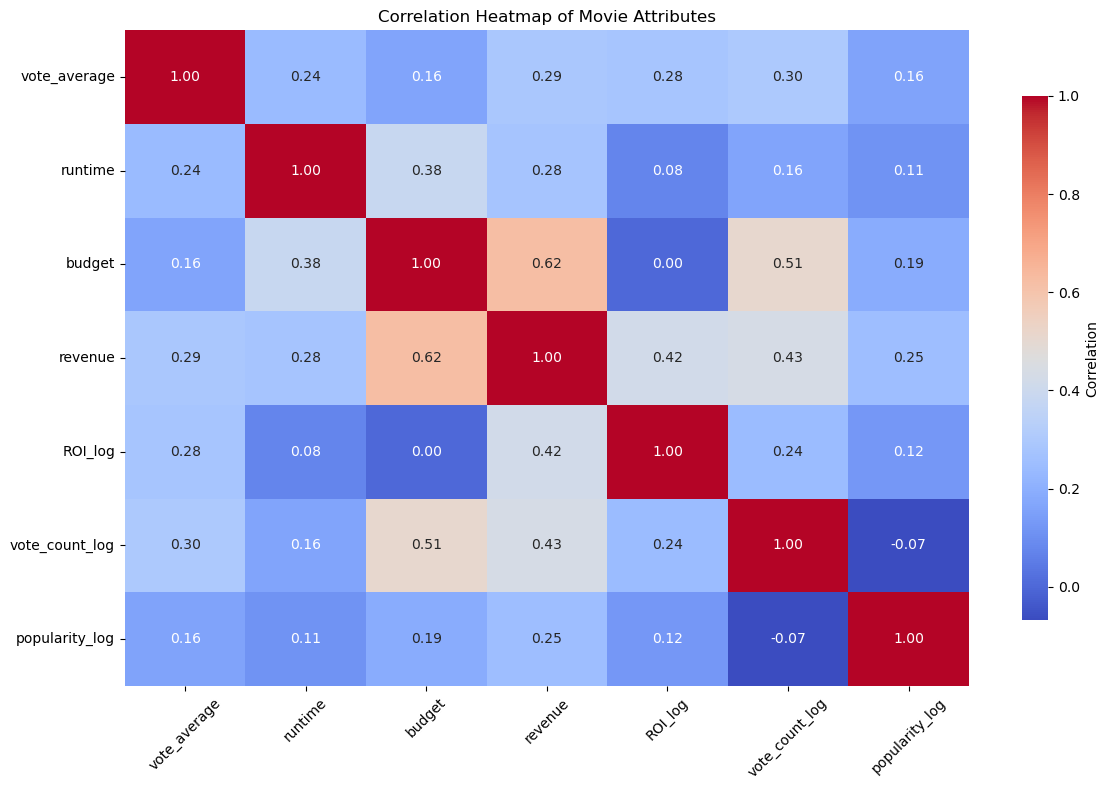

In [60]:
numeric_df = movie_data.select_dtypes(include="number").copy()

cols_to_drop = ["id", "ROI", "vote_count", "popularity", "release_year"]
numeric_df = numeric_df.drop(columns=[c for c in cols_to_drop])

corr = numeric_df.corr(method="pearson")

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
)
plt.title("Correlation Heatmap of Movie Attributes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 3.3.1 The Economics of Genre: which types of movies have the highest ROI?

In [37]:
"""Define type mapping dictionary"""
genre_lookup = {
    28: "Action", 12: "Adventure", 16: "Animation", 35: "Comedy",
    80: "Crime", 99: "Documentary", 18: "Drama", 10751: "Family",
    14: "Fantasy", 36: "History", 27: "Horror", 10402: "Music",
    9648: "Mystery", 10749: "Romance", 878: "Sci-Fi", 10770: "TV Movie",
    53: "Thriller", 10752: "War", 37: "Western"
}

In [38]:
def parse_genres(val):
    if isinstance(val, list):
        return val
    if isinstance(val, str) and val.strip():
        try:
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list):
                return parsed
        except (ValueError, SyntaxError):
            cleaned = val.strip().strip("[]")
            return [item.strip().strip("'\"") for item in cleaned.split(",") if item.strip()]
    return []

movie_data["genre_ids"] = movie_data["genre_ids"].apply(parse_genres)

"""Explode and convert the existing generation id to type name"""
selcect_cols = ["id", "title", "genre_ids", "ROI", "ROI_log"]
movie_explod = movie_data[selcect_cols].explode("genre_ids")
movie_explod["genre_id"] = movie_explod["genre_ids"].astype(int)
movie_explod["type_name"] = movie_explod["genre_id"].map(genre_lookup)

In [39]:
"""Aggregate statistics: calculates statistical indicators for each type."""
movie_stats = movie_explod.groupby("type_name").agg(
    movie_count=("id", "nunique"),
    median_roi=("ROI", "median"),
).sort_values("median_roi", ascending=False)

In [40]:
"""Film genres with fewer than 5 films were excluded from the statistical scope to avoid the possibility of randomness in the analysis."""
min_sample_size = 5
movie_stats = movie_stats[movie_stats["movie_count"] >= min_sample_size].reset_index()

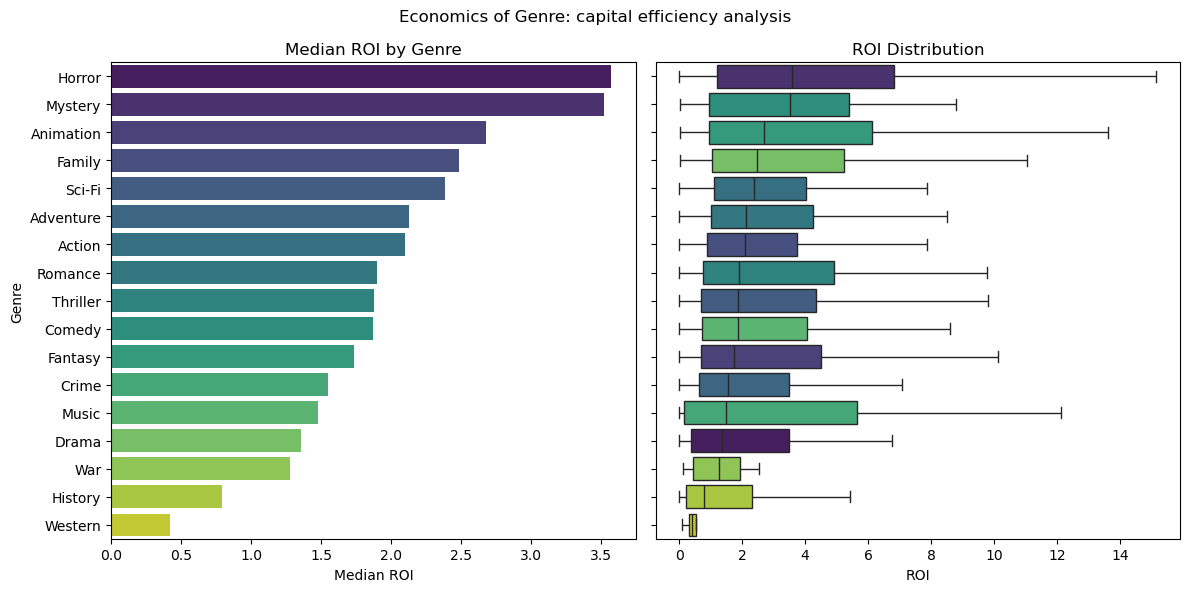

In [41]:
"""Ensure the y-axis are arranged in the same order."""
type_order = movie_stats["type_name"].tolist()
palette = sns.color_palette("viridis", n_colors = len(type_order))

"""Visualizing different types of movies"""
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
sns.barplot(
    data=movie_stats,
    x = "median_roi",
    y = "type_name",
    hue = "type_name",
    order=type_order,
    palette=palette,
    ax=axes[0]
)
axes[0].set_title("Median ROI by Genre")
axes[0].set_xlabel("Median ROI")
axes[0].set_ylabel("Genre")


sns.boxplot(
    data=movie_explod[movie_explod["type_name"].isin(type_order)],
    x = "ROI",
    y = "type_name",
    hue = "type_name",
    order=type_order,
    palette=palette,
    ax=axes[1],
    showfliers=False,
)
axes[1].set_title("ROI Distribution")
axes[1].set_xlabel("ROI")
axes[1].set_ylabel("") 

plt.suptitle("Economics of Genre: capital efficiency analysis")
plt.tight_layout()
plt.show()

Tips:"Median ROI" represents the **average profitability** of this type of film.

Based on the analysis of `genre_id` and `ROI` values, we can draw the following conclusions:

1. Profitability Assessment: High return and ROI:
 - **horror movies** top the list, reflecting the significant cost control advantages in content production.
 - **historical, war and western movies** perform poorly in terms of pure commercial returns. Unless there are specific artistic or award goals, careful selection is advised.

2. Investment Risk and Stability Analysis:
 - best risk-reward structure: **horror movies** have a high `ROI` and significant potential for returns.This represents **high stability and high potential for explosive growth**. Even ordinary horror films can get a high return on investment. Once a blockbuster hits, the return will be unpredictable.
 - Safe and stable investment options: **animation** and **science fiction**. The animation's box layout is relatively stable and located at a high position which means **strong market demand**.Its investment failure rate is far lower than that of action movies.

In conclusion, film genre(`genre_id`) is an important factor influencing a movie's ROI.


#### 3.3.2 Best `runtime`: Is there any golden movie `runtime` period that maximizes ROI?  
I first organized and visualized the ROI distribution of movies with different runtimes.

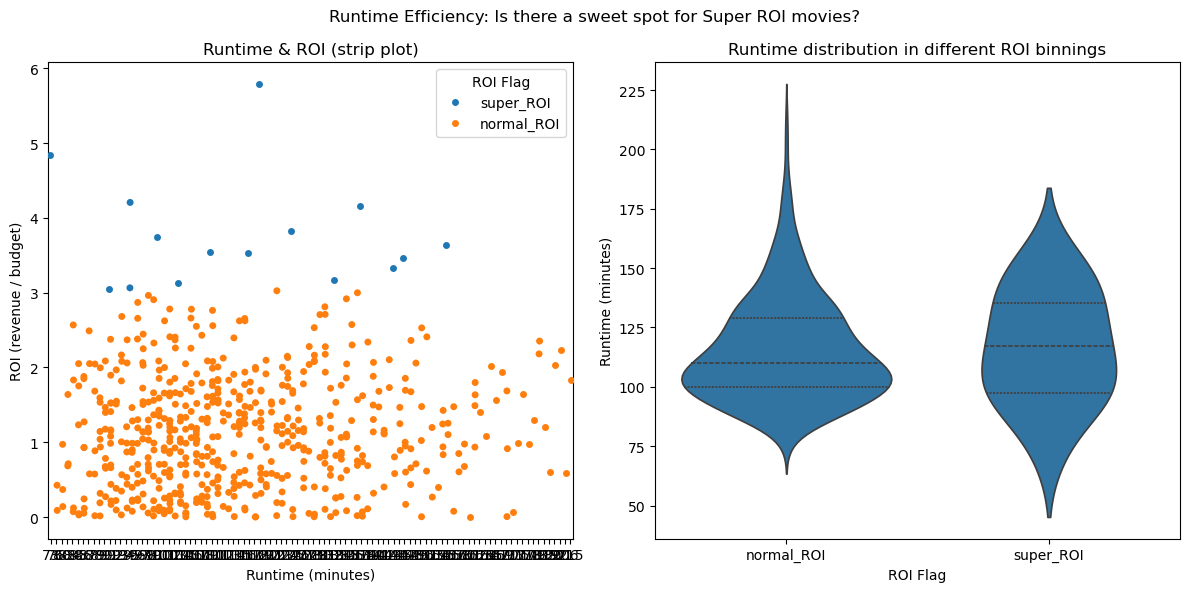

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.stripplot(
    data=movie_data,
    x="runtime",
    y="ROI_log",
    hue="ROI_flag",
    dodge=True,
    ax=axes[0]
)
axes[0].set_title("Runtime & ROI (strip plot)")
axes[0].set_xlabel("Runtime (minutes)")
axes[0].set_ylabel("ROI (revenue / budget)")
axes[0].legend(title="ROI Flag")

sns.violinplot(
    data=movie_data,
    x="ROI_flag",
    y="runtime",
    inner="quart",
    ax=axes[1]
)
axes[1].set_title("Runtime distribution in different ROI binnings")
axes[1].set_xlabel("ROI Flag")
axes[1].set_ylabel("Runtime (minutes)")

fig.suptitle("Runtime Efficiency: Is there a sweet spot for Super ROI movies?")
plt.tight_layout()
plt.show()


Clearly, judging from the distribution of `runtime` within different `ROI_flag`, it does not possess a typical golden `runtime`.  
So I calculated the mean `ROI_log` for all movies with the same runtime: `runtime_bins`. Find the 75 percentile of the average `ROI_log`.

Find the 75th percentile of the `runtime_bins`, and include all runtime values ​​exceeding this percentile in the **golden runtime range**.

C:\Users\10525\AppData\Local\Temp\ipykernel_93864\1266745607.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("runtime_bin")


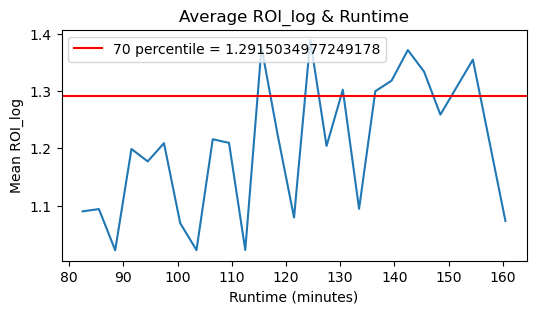

Possible golden runtime range:
(114, 117]
(123, 126]
(129, 132]
(135, 138]
(138, 141]
(141, 144]
(144, 147]
(153, 156]


In [43]:
runtime_ready = movie_data.copy()

min_rt = int(runtime_ready["runtime"].min() // 3 * 3)
max_rt = int(runtime_ready["runtime"].max() // 3 * 3 + 3)
bins = list(range(min_rt, max_rt, 3))

runtime_ready["runtime_bin"] = pd.cut(runtime_ready["runtime"], bins=bins)

runtime_bins = (
    runtime_ready
    .groupby("runtime_bin")
    .agg(roi_log_mean=("ROI_log", "mean"), count=("ROI_log", "size"))
    .reset_index()
)

"""runtime data with fewer than 5 samples are considered as noise."""
runtime_bins = runtime_bins[runtime_bins["count"] >= 5]
threshold = runtime_bins["roi_log_mean"].quantile(0.7)

runtime_bins = runtime_bins.assign(
    runtime_bin_center=runtime_bins["runtime_bin"].apply(lambda iv: iv.mid)
)

plt.figure(figsize=(6, 3))
sns.lineplot(data=runtime_bins, x="runtime_bin_center", y="roi_log_mean")
plt.axhline(threshold, label=f"70 percentile = {threshold}", color = "red")
plt.title("Average ROI_log & Runtime")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Mean ROI_log")
plt.legend(loc="upper left")
plt.show()

golden_bins = runtime_bins.loc[runtime_bins["roi_log_mean"] >= threshold, "runtime_bin"]
print("Possible golden runtime range:")
for _ in golden_bins:
    print(_)


Data `ROI_log` shows that the possible golden range for movie runtime is **138-150** minutes, which contradicts the common sense of cinema scheduling economics: **90-110** minutes.  
Here are some possible reasons:
 - The high threshold for long-runtime movies: only projects deemed to possess narrative value, top-tier production values, or strong "ip" backing are permitted to be made into long-runtime movies. Therefore, films in the 138-150 minute range generally have higher quality, budgets, and market expectations than those in the 90-minute range.
 - High returns: Although ong-runtime movies face limited screenings, their high ticket prices and longer theater life popularity may compensate for the lack of screenings  
 
 In conclusion, while the [129, 147] minute interval is a statistically "golden runtime period," it is not a low-cost, replicable investment strategy. It shows the return on **"top-tier resource investment"**, not a shortway to **"high ROI"**.


#### 3.3.3 `ROI` miracle
The more you invest, the higher the return usually is. This is the fundamental business logic of the movie industry. Let's take a look at which movies created the `ROI` miracle.

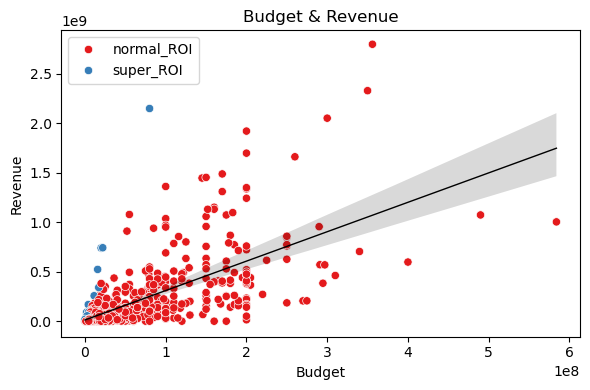

In [44]:
budget_ready = movie_data.copy()

plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=budget_ready,
    x="budget",
    y="revenue",
    hue="ROI_flag",
    palette="Set1"
)

sns.regplot(
    data=budget_ready,
    x="budget",
    y="revenue",
    scatter=False,
    color="black",
    line_kws={"linewidth": 1}
)

plt.title("Budget & Revenue")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

Clearly, `budget` and `revenue` have a strong positive correlation. The slope in the graph reflects the `ROI` value.   
However, we found that the movies in the `super_ROI` group that create `ROI` miracles are often low-budget blockbusters.

From an investment perspective, this is similar to the lottery: **"high risk, high reward"**.  
Meanwhile, a "fit" `ROI` sharply **less than 1** shows that movie production is not an ideal, robust investment choice.  

I'll explore the relationship between return on investment and movie attributes for now. Below, I will analyze `vote_average` , `popularity`, and `vote_count`.

#### 3.3.4 Popular but terrible movies?: The discrepancy between `vote_average` and `popularity`

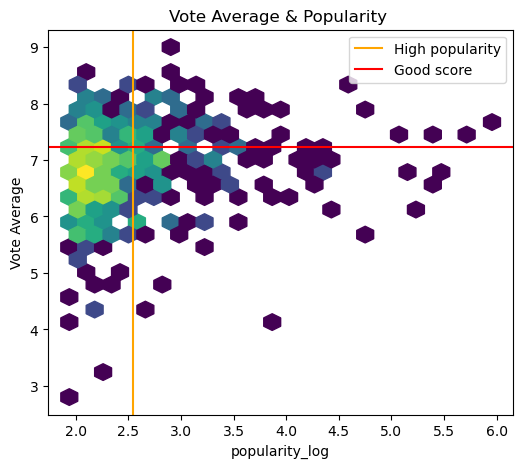

In [45]:
vote_ready = movie_data.copy()
vote_ready["popularity_log"] = np.log1p(vote_ready["popularity"])

plt.figure(figsize=(6, 5))
hb = plt.hexbin(
    vote_ready["popularity_log"],
    vote_ready["vote_average"],
    gridsize=25,
    cmap="viridis",
    bins="log",          
    mincnt=1
)

"""70% is used as the high score line"""
plt.axvline(np.log1p(vote_ready["popularity"].quantile(0.7)), color="orange", label="High popularity")
plt.axhline(vote_ready["vote_average"].quantile(0.7), color="red", label="Good score")
plt.title("Vote Average & Popularity ")
plt.xlabel("popularity_log")
plt.ylabel("Vote Average")

plt.legend()
plt.show()

From the density of the distribution of each film, it is easy to see that there is a certain linear positive correlation between `vote_avange` and `popularity`.  
- There weren't many movies with high `popularity` but low `vote_average`. This means that the dataset contains only a small number of popular but terrible movies.
- Conversely, there are a large number of high `vote_average` but low `popularity` films that can be considered "hidden gems."They have a strong reputation. Once they gain exposure through precise algorithmic recommendations, their high `vote_average` guarantee their potential for rediscovery.

In conclusion, this shows a supply-demand gap in the movie market: **high-quality content is not being fully discovered**. For companies that prioritize content depth and user experience, movies in this paet is a valuable untapped market.

#### 3.3.5 "positive relationship" between the `vote_count` and `popularity`？
Verify whether there is a strong linear relationship between the `vote_count` and `popularity`.

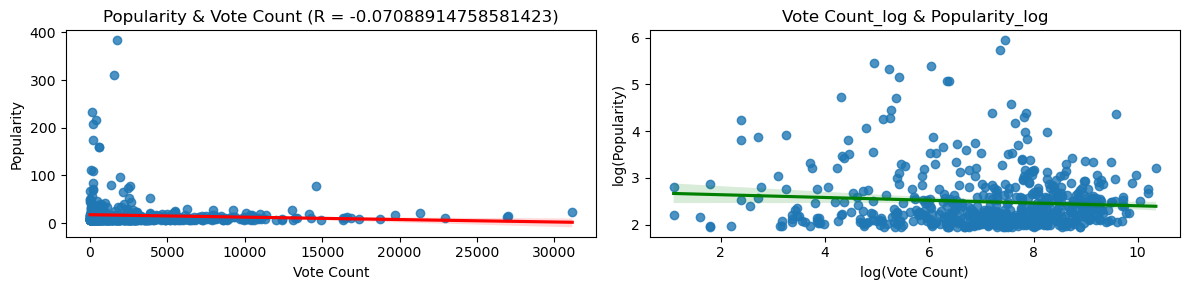

In [46]:
vote_count_ready = movie_data.copy()

"""Calculation of linear correlation coefficient"""
R = vote_count_ready[["vote_count", "popularity"]].corr().iloc[0, 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
sns.regplot(
    vote_count_ready,
    x="vote_count",
    y="popularity",
    line_kws={"color": "red"},
    ax=axes[0]
)
axes[0].set_title(f"Popularity & Vote Count (R = {R})")
axes[0].set_xlabel("Vote Count")
axes[0].set_ylabel("Popularity")

sns.regplot(
    vote_count_ready,
    x="vote_count_log",
    y="popularity_log",
    line_kws={"color": "green"},
    ax=axes[1]
)
axes[1].set_title("Vote Count_log & Popularity_log")
axes[1].set_xlabel("log(Vote Count)")
axes[1].set_ylabel("log(Popularity)")

plt.tight_layout()
plt.show()

insight:
 - As can be seen in the left graph, the linear correlation coefficient between the two variables is extremely low, at -0.036, indicating that they are not linearly correlated.   
 - In the right graph, the distribution points are more dispersed, showing no obvious correlation characteristics. Therefore, we speculate that the `vote_count` is not related to `popularity`. 
 
 The conclusion is counterintuitive, meaning that "more comments" do not necessarily equate to "greater popularity". This may stem from differences in the TMDB's algorithms.

## 4: Ask a question about your data：Which genre demonstrates the strongest post-pandemic (2020-2025) investment resilience, and what is the optimal product profile (runtime, vote_average, popularity) that drives that advantage?


Step 3 showed that Horror titles led the ROI leaderboard. To validate whether this advantage persists after COVID-19 disruptions, I focus on the post-pandemic window (2020-2025) and inspect how capital efficiency behaves through time and across product attributes.


### 4.1 Main Question

Which genre demonstrates the strongest post-pandemic (2020-2025) investment resilience, and what is the optimal product profile (`runtime`, `vote_average`, `popularity`) that sustains that advantage?


### 4.2 Sub-questions

Sub-Q1 - Trend Analysis: How has the average `ROI` of major genres evolved year by year since 2020? Does the **Horror genre** show a consistent advantage over high-budget genres like Action?

Sub-Q2 - Risk Assessment: Among the high-performing genres, which one offers the lowest standard deviation of `ROI`?

Sub-Q3 - Micro-Profiling: Focusing on the best-performing genre identified (Horror), is there an "optimal product profile"? specifically:

 - Does a shorter `runtime` correlate with higher ROI?
 - Is `vote average` a prerequisite for financial success?
 - How do features drive the returns?


#### 4.2.1 how has the average `ROI` of major genres evolved year by year since 2020? Does the Horror genre show a consistent advantage over high-budget genres like Action?

In [47]:
"""Filtering to the post-pandemic window keeps every subsequent visual tied to the investment resilience brief."""
movie_data['release_year'] = pd.to_datetime(movie_data['release_date'], errors='coerce').dt.year
movie_data = movie_data[movie_data['release_year'] >= 2020].copy()

genre_ready = (
    movie_data[['id', 'title', 'release_year', 'genre_ids', 'ROI', 'ROI_log','runtime', 'vote_average', 'popularity', "vote_count_log", "budget", "revenue"]]
    .explode('genre_ids')
)
genre_ready['genre_id'] = genre_ready['genre_ids'].astype(int)
genre_ready['genre_name'] = genre_ready['genre_id'].map(genre_lookup)

top_genres = (
    genre_ready.groupby('genre_name')['ROI']
    .mean()
    .sort_values(ascending=False)
    .head()
    .index
)
trend_data = genre_ready[genre_ready['genre_name'].isin(top_genres)]


c:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


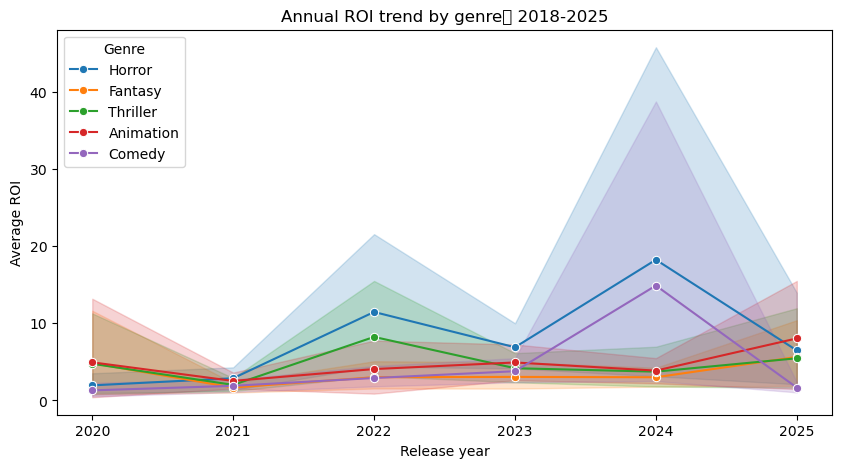

In [48]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=trend_data,
    x="release_year",
    y="ROI",
    hue="genre_name",
    marker="o"
)
plt.title("Annual ROI trend by genre： 2018-2025")
plt.xlabel("Release year")
plt.ylabel("Average ROI")
plt.legend(title="Genre", loc="upper left")
plt.show()

The line chart reveals a distinct divergence in post-pandemic recovery. While traditional high-budget genres like Action and Adventure maintained flat and low ROI (near the baseline), the Horror genre (green line) demonstrated explosive volatility and growth. Notably, there is a massive spike in average ROI around 2022, reaching levels higher than any other genres. 

Insight: This suggests that **Horro**r is a "counter-cyclical" asset. During the pandemic recovery phase, when expensive productions faced delays and inflated costs, low-budget Horror films capitalized on market gaps, delivering outsized returns. This conclusion further confirms the conclusion we reached in step 3.

#### 4.2.2 Risk Assessment: Among the high-performing genres, which one offers the lowest standard deviation of ROI ?

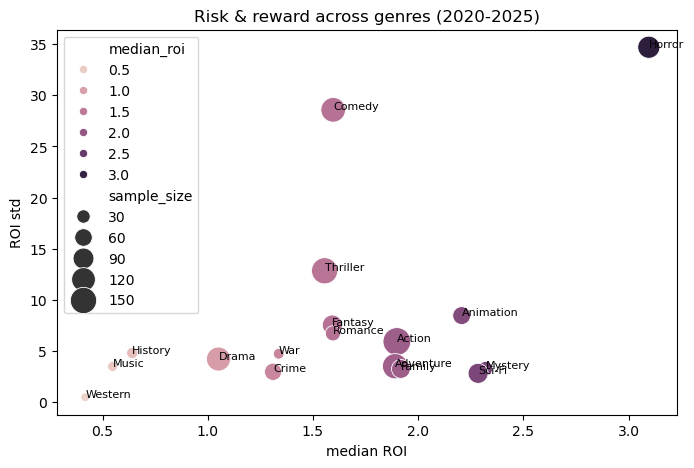

In [49]:
"""Plotting median ROI against ROI_std as a bubble chart reveals the most resilient high-return genre."""
risk_table = (
    genre_ready.groupby('genre_name')['ROI']
    .agg(median_roi='median', std_roi='std', sample_size='size')
    .reset_index()
)
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=risk_table,
    x='median_roi',
    y='std_roi',
    size='sample_size',
    sizes=(40, 400),
    hue='median_roi',
)
for _, row in risk_table.iterrows():
    plt.text(row['median_roi'], row['std_roi'], row['genre_name'], fontsize=8)
plt.title('Risk & reward across genres (2020-2025)')
plt.xlabel('median ROI')
plt.ylabel('ROI std')
plt.show()


Observation: The scatter plot positions Horror in the upper-right quadrant, characterizing it as a "High reward, High risk" strategy.
Horror has a  higher Average ROI but also a larger Standard Deviation. In comparison, mystery, Sci-H and animation also have good ROI and lower variance (lower risk).

Insight: 
 - While horror is "riskier" due to high std, this volatility is driven by asymmetric upside rather than massive losses which means production budgets of horrors are low. 
  - For investors, this implies that a portfolio approach: **investing in both in a animation movie and muti-horror movies rather than a single one to hedge risks**. It is the best strategy to mitigate individual volatility while capturing the high average returns.

#### 4.2.3 Micro-Profiling: Focusing on the best-performing genre identified (Horror and Animation), is there an "optimal product profile"?

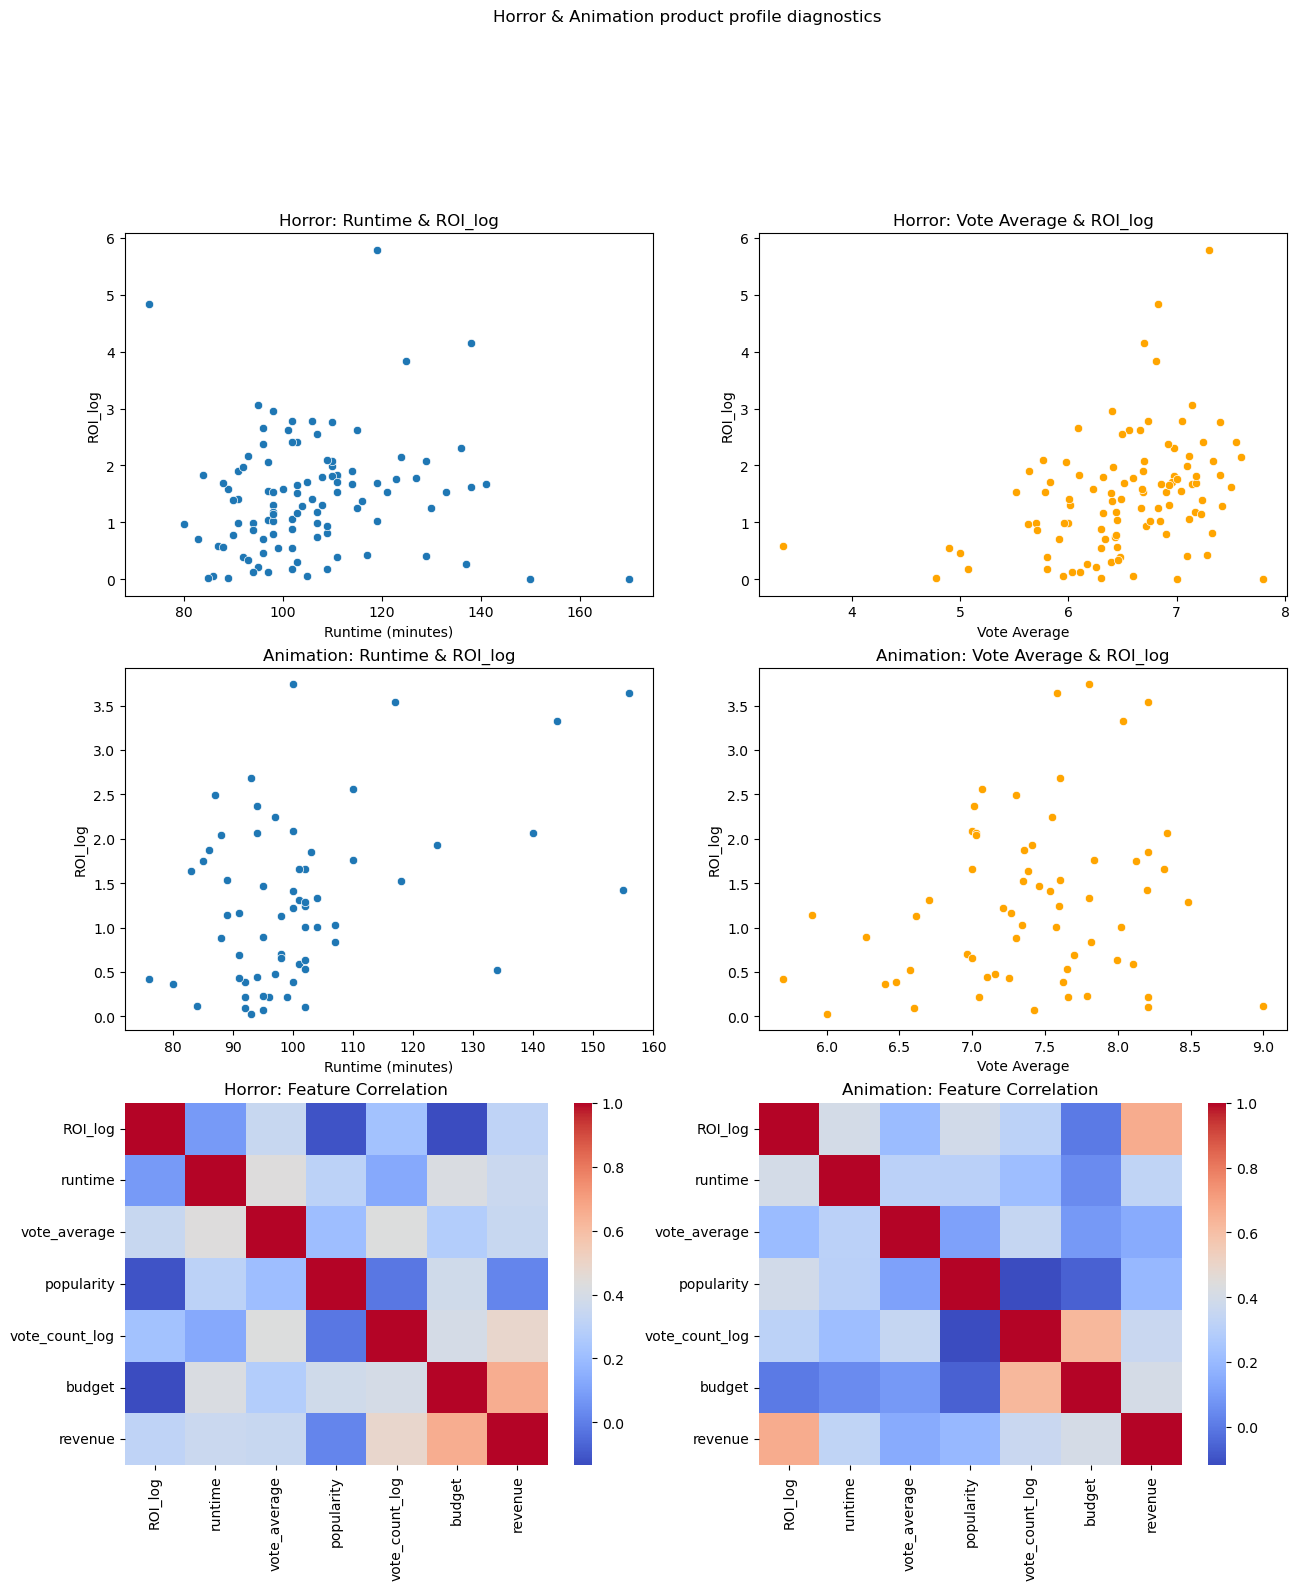

In [50]:
"""Small multiples isolate Horror to study how runtime, vote_average, and popularity co-move with ROI."""
target_genres = ["Horror", "Animation"]
profiles = {g: genre_ready[genre_ready["genre_name"] == g].copy() for g in target_genres}

fig, axes = plt.subplots(3, 2, figsize=(15,16))

for row, genre in enumerate(target_genres):
    profile = profiles[genre]
    sns.scatterplot(
        data=profile,
        x="runtime",
        y="ROI_log",
        ax=axes[row, 0]
    )
    axes[row, 0].set_title(f"{genre}: Runtime & ROI_log")
    axes[row, 0].set_xlabel("Runtime (minutes)")
    axes[row, 0].set_ylabel("ROI_log")

    sns.scatterplot(
        data=profile,
        x="vote_average",
        y="ROI_log",
        ax=axes[row, 1],
        color = "orange"
    )
    axes[row, 1].set_title(f"{genre}: Vote Average & ROI_log")
    axes[row, 1].set_xlabel("Vote Average")
    axes[row, 1].set_ylabel("ROI_log")

    corr = profile[['ROI_log','runtime', 'vote_average', 'popularity', 'vote_count_log', 'budget', 'revenue']].corr()
    sns.heatmap(
        corr,
        cmap="coolwarm",
        ax=axes[2, row],
    )
    axes[2, row].set_title(f"{genre}: Feature Correlation")

plt.suptitle("Horror & Animation product profile diagnostics", y=1.02)
plt.show()


insight: The analysis shows a striking contrast in investment logic between the two genres:

 - Horror:Crucially, financial success here is driven almost exclusively by marketing hype (vote_average) and artistic quality, making it a speculative asset class. Runtime is not a significant driving factor.

 - Animation: it models as "Defensive Anchor" characterized by "Quality and Reach." The positive trend in runtime suggests audiences reward richer, longer storytelling (above 100 minutes). `ROI` in Animation is strongly tied to high ratings and word-of-mouth accumulation, proving that product quality is the primary safety net for capital. 
 
 the data shows a "Barbell Strategy": utilizing low-budget Horror for short-term speculative spikes while relying on high-quality Animation for long-term growth.

## 5: Summarise and write a conclusion

### 5.1 Key findings 

The underlying logic of investment and market opportunities

 - The overall financial structure of film investment exhibits typical characteristics of a "head effect" and "lottery-like returns." A very small number of films with high returns contribute the vast majority of profits, while most projects struggle to recoup their costs.

 - The data shows an undervalued opportunity in the market: "clod gems" with high ratings but low popularity, Which have the potential to generate asymetric excess returns through sophisticated distribution and secondary marketing.

 - Runtime of movie itself is not a condition for high returns. Longer durations often involve "heavy investment bets" with extremely high budgets and best resources, which are difficult to replicate in ordinary projects.

Portfolio strategy: the dumbbell strategy

In the post-pandemic era, Horror movies significantly outperformed the average Return on Investment (ROI), exhibiting clear counter-cyclical asset characteristics. This genre belongs to a high-volatility, high-return offensive asset class. Conversely, Animated movies showed markedly less volatility, forming a more robust defensive return structure.Micro-level characteristics reveal two distinct success profiles:
 - The success of Horror movies relies on high-quality and hidden reasons (eg: Excellent marketing).

 - The success of Animated movies depends on high-quality production and positive word-of-mouth.

 The final investment decision, is to use a large portfolio of low-cost Horror movies to generate excess returns, while anchoring the fund with a small number of high-investment Animated features as ballast for stable cash flow, and achieving the optimal portfolio return.


### 5.2 Reflection on process and limitations

In this project, I followed a complete analytical pipeline: data crawling, cleaning, feature engineering , EDA and finally a genre-focused deep analysis. This structure helped me gradually move from describing the market (distributions and correlations) to answering a concrete business question (which and why movie types are most attractive after 2020).

However, the analysis still has several limitations. First, the dataset is constrained by the platform’s availability: many titles have missing or unreliable budget/revenue information, and I had to remove extreme outliers through ad-hoc thresholds. Second, most insights are based on descriptive statistics and correlations, Instead of a causal model. We cannot ensure whether certain features truly drive higher ROI or just correlate with other unobserved factors such as marketing spend or IP strength.

In summary, I focus more on visual exploration and statistical summarization than on formal modeling. However, in real-world investment environments, further robustness testing is needed to translate these findings into practical capital allocation decisions. Therefore, this is closely related to my future work; if necessary, I will learn machine learning models to determine the weights of each feature on ROI to obtain more accurate and detailed predictions.

### 5.3 Future work

Build predictive models for ROI – Instead of relying only on descriptive statistics, I would like to build regression or tree-based models to predict ROI using genre, budget, runtime, rating and popularity as features, and compare the feature importance across models.

Incorporate more revenue channels and time dynamics – The current revenue mainly comes from aggregated box-office or a single source. Future work could separate theatrical, streaming and international revenue, and use panel data to study how long-tail titles (such as “cold movies with high vote_average”) generate value over time.